In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60
%matplotlib inline
from ivanocode.ivanocommon import *
import pandas as pd

Autosaving every 60 seconds


In [2]:
df_sales_train_melt = pd.read_feather('df_sales_train_melt.feather')

In [3]:
df_sales_train_melt.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,daily_avg_count,monthly_avg_count,day_date,day_date_str,month_id,month,year,date,wm_yr_wk,sell_price,sell_price_flip_count
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.313643,9.409305,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.257710,7.731312,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1


In [4]:
df_sales_train_melt['id'].nunique()

30490

In [5]:
sample_ids = df_sales_train_melt['id'].unique()[0:100]

In [6]:
df_sample = df_sales_train_melt.query('id in @sample_ids')

In [7]:
# needed for the feather
df_sample.reset_index(drop=True, inplace=True)

In [8]:
df_sample.to_feather('df_sales_train_melt_sample100series.feather')

In [9]:
len(df_sample)

191300

In [10]:
from fastai.tabular import *

In [11]:
day_ids = list(sorted(df_sample['day_id'].unique()))
len(day_ids)

1913

In [12]:
valid_idx = np.flatnonzero(df_sample['day_id'] > 1800)

In [13]:
procs = [FillMissing, Categorify, Normalize]
dep_var = 'sales'
cat_names = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month_id', 'id']
# TODO: see what else other than SNAP's and holidays is missing from the original data
cols = cat_names + ['sell_price'] + [dep_var]

In [14]:
path ='./tmp'
# TODO: check how dates with no sales are represented
data = TabularDataBunch.from_df(path, df_sample[cols], dep_var, valid_idx=valid_idx,
                                procs=procs, cat_names=cat_names)

/usr/local/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
62, 75
  if getattr(ds, 'warn', False): warn(ds.warn)


In [15]:
learn = tabular_learner(data, layers=[200,100], emb_szs=None, metrics=accuracy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


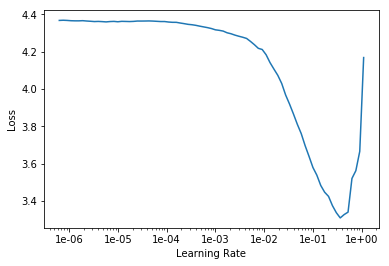

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, 2e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.141443,1.339569,0.539210,05:53
1,1.086305,1.263952,0.589131,05:54
2,1.009890,1.184772,0.599664,06:08


In [18]:
# 8865760240
# df_sales_train_melt.values.nbytes

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


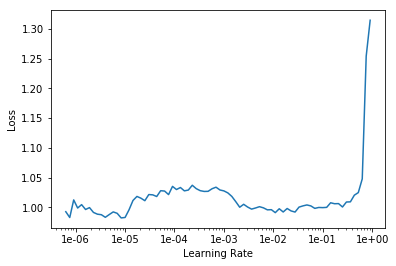

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
list(sorted(df_sales_train_melt['day_date'].unique()))[:1]

[numpy.datetime64('2011-01-29T00:00:00.000000000')]

In [21]:
df_sample_submission = pd.read_csv('raw/sample_submission.csv')
df_sample_submission.head()
from datetime import timedelta
d_1_date = pd.to_datetime('2011-02-08')
mapping = {f'F{day}':(d_1_date + timedelta(days=day-1)).date() for day in range(1,29)}
mapping['id'] = 'id'
# TODO: sell_price should come from last sales day
df_sample_submission.columns = df_sample_submission.columns.map(mapping)
df_sample_submission_melt = df_sample_submission.melt(id_vars='id', var_name='day', value_name='sales')
df_sample_submission_melt.head(1)

,id,day,sales
0,HOBBIES_1_001_CA_1_validation,2011-02-08,0


In [23]:
last_prices = df_sales_train_melt[['id', 'sell_price']].groupby('id').tail(1)
last_prices.head(1)

,id,sell_price
58296880,HOBBIES_1_001_CA_1_validation,8.38
58296881,HOBBIES_1_002_CA_1_validation,3.97
58296882,HOBBIES_1_003_CA_1_validation,2.97
58296883,HOBBIES_1_004_CA_1_validation,4.64
58296884,HOBBIES_1_005_CA_1_validation,2.88


In [31]:
df_sample_submission_melt = df_sample_submission_melt.merge(
    last_prices, on='id', how='left', validate='many_to_one')

In [55]:
t = df_sample_submission_melt.head(100).copy()
t.head()

,id,day,sales,sell_price
0,HOBBIES_1_001_CA_1_validation,2011-02-08,0,8.38
1,HOBBIES_1_002_CA_1_validation,2011-02-08,0,3.97
2,HOBBIES_1_003_CA_1_validation,2011-02-08,0,2.97
3,HOBBIES_1_004_CA_1_validation,2011-02-08,0,4.64
4,HOBBIES_1_005_CA_1_validation,2011-02-08,0,2.88


In [43]:
df_sales_train_melt.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,daily_avg_count,monthly_avg_count,day_date,day_date_str,month_id,month,year,date,wm_yr_wk,sell_price,sell_price_flip_count
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.313643,9.409305,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1


In [71]:
def extract_id_columns(t):
    extracted = t['id'].str.extract('([A-Z]+)_(\\d)_(\\d{3})_([A-Z]{2})_(\d)')
    t['cat_id'] = extracted[0]
    t['dept_id'] = t['cat_id'] + '_' + extracted[1]
    t['item_id'] = t['cat_id'] + '_' + extracted[2]
    t['state_id'] = extracted[3]
    t['store_id'] = t['state_id'] + '_' + extracted[4]

    t['state_id'] = state_id
    return t

extract_id_columns(t).head(1)

,0,1,2,3,4
0,HOBBIES,1,001,CA,1


,id,day,sales,sell_price,dept_id,state_id,cat_id,item_id,store_id
0,HOBBIES_1_001_CA_1_validation,2011-02-08,0,8.38,HOBBIES_1,2,HOBBIES,HOBBIES_001,CA_1


In [73]:
df_sample_submission_melt = extract_id_columns(df_sample_submission_melt)

,0,1,2,3,4
0,HOBBIES,1,001,CA,1


In [80]:
df_sample_submission_melt['month_id'] = pd.to_datetime(df_sample_submission_melt['day']).dt.month

In [81]:
data = TabularDataBunch.from_df(path, df_sample[cols], dep_var, valid_idx=valid_idx,
                                procs=procs, cat_names=cat_names, test_df=df_sample_submission_melt)

In [83]:
learn.data = data

In [84]:
preds, y = learn.get_preds(DatasetType.Test)

In [88]:
# Note to self: this looks like a trained classifier :D
preds.size()

torch.Size([1707440, 73])

In [89]:
learn

Learner(data=TabularDataBunch;

Train: LabelList (180000 items)
x: TabularList
item_id HOBBIES_1_001; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_001_CA_1_validation; sell_price_na True; sell_price -0.2554; ,item_id HOBBIES_1_002; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_002_CA_1_validation; sell_price_na True; sell_price -0.2554; ,item_id HOBBIES_1_003; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_003_CA_1_validation; sell_price_na True; sell_price -0.2554; ,item_id HOBBIES_1_004; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_004_CA_1_validation; sell_price_na True; sell_price -0.2554; ,item_id HOBBIES_1_005; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_005_CA_1_validation; sell_price_na True; sell_price -0.2554; 
y: CategoryList
0,0,0,0,0
Path: tmp;

Valid: LabelList (